# Vector Efficiency: Why Zeros Are Costing You Memory

When we want to create something like a search engine, we need to convert both our query (the thing we're searching for) and our corpus (the documents we're searching over) into something computers can easily understand. The best thing for this a vector. A vector is simply a list of numbers that represent the information. That being said, there are considerations to be made when dealing with vectors. What sort of memory budget do we have? What sort of speed requirements? 

Two approaches are **sparse** vectors and **dense** vectors. Sparse vectors are vectors that contain mostly zeros. Dense vectors are vectors that contain mostly non-zeros.

Think about your Netflix watch history. You've probably watched a small fraction of all available movies. If Netflix stored every possible movie as a giant list, marking unseen movies as '0' and watched ones as '1,' that would be a sparse vector—mostly empty. But if Netflix stored a list of your genre preferences (Action: 0.7, Comedy: 0.5, Sci-Fi: 0.8), that would be a dense vector—every value carries meaning.

## Sparse vs. Dense Vectors

To wrap our head around the difference between sparse and dense vectors, we'll use `numpy` to create both types of vector. So we can (somewhat) accurately get an idea of how much memory is occupied, we'll use the `np.int8` datatype. We'll create vectors of size 1024 to illustrate the difference between the two.

For reproducability, we'll use [numpy's `default_rng`](https://numpy.org/doc/2.1/reference/random/generator.html#numpy.random.default_rng) generator for all of our random data.

In [ ]:
import numpy as np
from rich import print

random_number_generator = np.random.default_rng(seed=42)

In [ ]:
vector_length = 1024

To create our sparse vector, we initialize with all zeros, randomly select 1% of the length of our vector as indices, and fill those indices with values between 1 and 5.

In [ ]:
sparse_vector = np.zeros(vector_length, dtype=np.int8)
indices_to_fill = random_number_generator.choice(vector_length,size=int(vector_length*0.01), replace=False)
sparse_vector[indices_to_fill] = random_number_generator.integers(low=1,high=6, size=indices_to_fill.size)

print(sparse_vector)

[0 0 0 ... 0 0 0]

For our dense vector, we create a vector of the same size (1024) and fill it with random integers between 0 and 5.

In [ ]:
dense_vector = random_number_generator.integers(low=0,high=6, size=vector_length, dtype=np.int8)

print(dense_vector)

[4 3 3 ... 0 4 2]

To see the difference between sparse and dense vectors, we can turn each vector into a 32x32 grid and plot it with a colormap that represents each value between 0 and 5.

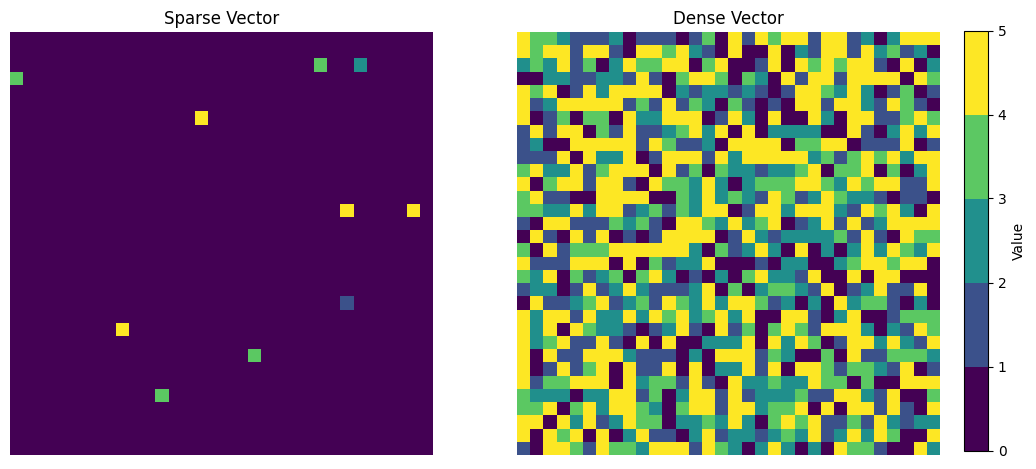

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_vectors_side_by_side(sparse_vector, dense_vector):
    size = int(np.ceil(np.sqrt(len(sparse_vector))))

    sparse_grid = sparse_vector.reshape(size, size)
    dense_grid = dense_vector.reshape(size, size)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1]})

    num_bins = 6
    cmap = plt.cm.viridis
    bounds = np.linspace(0, 5, num_bins, dtype=np.int8)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    im1 = axes[0].imshow(sparse_grid, cmap=cmap, norm=norm)
    axes[0].set_title("Sparse Vector")
    axes[0].axis("off")

    im2 = axes[1].imshow(dense_grid, cmap=cmap, norm=norm)
    axes[1].set_title("Dense Vector")
    axes[1].axis("off")


    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im2, cax=cbar_ax)
    cbar.set_label("Value")
    cbar.set_ticks(bounds)

    plt.show()

plot_vectors_side_by_side(sparse_vector, dense_vector)

## Sparse and Dense Vector Representation

Our sparse vector when initialized was sparse in the mathematical sense because it contained mostly zeros. However, it was in a Dense Representation because each value was allocated in memory. As the size of our vectors grow, it seems wasteful to allocate memory for a bunch of zeroes since they don't add much information. We can take advantage of the sparsity and transform it into a Sparse Representation. With a sparse representation, we'll still capture all of the non-zero values (which in our example are the only thing that are important), but we'll greatly reduce the memory footprint.  This mainly comes down to the datatype we're using to store our vectors.

To go from sparse vector to sparse vector representation, we'll use a `dict` that has the index as the key and the value at that index for the actual value entry.

In [ ]:
sparse_vector_dict = {i: sparse_vector[i] for i in indices_to_fill}
print(sparse_vector_dict)

{87: 3, 786: 3, 90: 2, 665: 1, 446: 5, 441: 4, 712: 4, 96: 3, 206: 5, 875: 3}

Indexing into our array, we get exactly what we expect.

In [ ]:
print(f"Value at index {indices_to_fill[0]} in sparse vector: {sparse_vector[indices_to_fill[0]]}")
print(f"Value at index {indices_to_fill[-1]} in sparse vector: {sparse_vector[indices_to_fill[-1]]}")

Value at index 87 in sparse vector: 3

Value at index 875 in sparse vector: 3

Because our vector length was 1024 and our sparse vector had 1% non-zero values, rounding down we expect 10 non-zero values.

$$
1024\times0.01=10.24 \\
\lfloor 10.24 \rfloor = 10
$$

In [ ]:
print(f"Number of stored elements using sparse representation: {len(sparse_vector_dict)}")

Number of stored elements using sparse representation: 10

## Optimizing Memory with a Sparse Representation

While not a perfect comparison, we can look at the memory that our sparse vector vs its sparse representation. During creation, we used numpy's `int8` datatype for our random integers. This is used to represent 8-bit signed integers ranging from -128 to 127. While we may expect the size of our `int8` to be 1 byte (8 bits), `int8`s are still python objects that contain additional metadata. This results in quite a bit more memory consumption than we may assume.

In [ ]:
import sys

In [ ]:
print(f"int8 value: {sparse_vector[0]}")
print(f"Memory usage for int8: {sys.getsizeof(sparse_vector[0])} bytes")

int8 value: 0

Memory usage for int8: 25 bytes

If we look at the memory usage of the entire sparse vector and its corresponding sparse vector representation, we see that we can represent the same information in a much smaller footprint. This is true even though both the `dict` and `np.array` have overhead as well.

In [ ]:
sparse_vector_memory=sys.getsizeof(sparse_vector)
sparse_representation_memory=sys.getsizeof(sparse_vector_dict)

print(f"Memory usage for sparse vector: {sparse_vector_memory} bytes.")
print(f"Memory usage for sparse vector using sparse representation: {sparse_representation_memory} bytes.")

Memory usage for sparse vector: 1136 bytes.

Memory usage for sparse vector using sparse representation: 352 bytes.

Looking at the ratio between the two values, we see a memory savings of over 3x, or roughly 70%.

In [ ]:
print(sparse_vector_memory/sparse_representation_memory)

3.227272727272727

$$
\frac{1136-352}{1136}\times100=69.01\%
$$

In practice, we probably wouldn't use a `dict` for our sparse representation. If we're sticking with python, we'd use something like [`scipy.sparse`](https://docs.scipy.org/doc/scipy/reference/sparse.html#sparse-arrays-scipy-sparse) and choose from one of its several [sparse formats](https://docs.scipy.org/doc/scipy/reference/sparse.html#usage-information).

For our illustration, we'll use the [`lil_array`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_array.html#scipy.sparse.lil_array) format.

In [ ]:
from scipy.sparse import lil_array

In [ ]:
scipy_sparse_vector=lil_array(sparse_vector)
print(scipy_sparse_vector)

(0, 87)       3
  (0, 90)       2
  (0, 96)       3
  (0, 206)      5
  (0, 441)      4
  (0, 446)      5
  (0, 665)      1
  (0, 712)      4
  (0, 786)      3
  (0, 875)      3

In [ ]:
scipy_sparse_vector_memory=sys.getsizeof(scipy_sparse_vector)
print(f"Memory usage for lil_array: {scipy_sparse_vector_memory} bytes")

Memory usage for lil_array: 56 bytes

This is a much better memory footprint reducing our initial 1136 bytes to only 56. From our starting point, this is a reduction of over 20x, or roughly 95%.

In [ ]:
print(sparse_vector_memory/scipy_sparse_vector_memory)

20.285714285714285

$$
\frac{1136-56}{1136}\times100=95.07\%
$$